## A) Import libs 

In [2]:
import torch 
import torch.nn as nn
import numpy as np 
import math
import matplotlib.pyplot as plt 
import gpytorch

from GPcustom.models import GPytorchFixed
from DataSet import DataSet

## B) Import model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class MapUpdateNetwork_7(nn.Module):
    """
    A convolutional neural network designed for processing and updating map-like structures.
    The network takes four input images as input, encodes their features, and decodes them 
    to generate an output map of the same spatial dimensions as the inputs.

    Attributes:
        encoder (nn.Sequential): Encoder that reduces spatial dimensions and extracts high-level features.
        decoder (nn.Sequential): Decoder that reconstructs the spatial dimensions from encoded features.

    Methods:
        __init__(in_channels, out_channels, out_channels_first_conv):
            Initializes the network with configurable input/output channels and feature depth.
        forward(img1, img2, img3, img4):
            Performs the forward pass by concatenating the input images, encoding their features, 
            and decoding them to produce the final map.
    """

    def __init__(self, in_channels=4, out_channels=2, out_channels_first_conv=16, std_max=math.sqrt(1+0.05)):
        """
        Initializes the MapUpdateNetwork.

        Args:
            in_channels (int): Number of input channels. Defaults to 4 (for concatenated input images).
            out_channels (int): Number of output channels. Defaults to 2.
            out_channels_first_conv (int): Number of channels in the first convolutional layer. Defaults to 16.
            std_max(float, obtional): correspond à la valeur maximale atteignable par std. Pour la calculer, il existe la formule suivante :
                                                        std_max = sqrt(outputscale+noise)
                                      Default to sqrt(1+0.05)
        """
        super(MapUpdateNetwork_7, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(4*out_channels_first_conv, 8*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(8*out_channels_first_conv, 16*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels_first_conv, 8*out_channels_first_conv, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4*out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU()
        )
        self.final_layer1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) 
        self.final_layer2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), 
            nn.Sigmoid()
        )

        self.train_losses = []
        self.validation_losses = []
        self.std_max = std_max

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Combines four input images, processes them through
        an encoder-decoder architecture, and outputs an updated map.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, C, H, W).
            img2 (torch.Tensor): Second input image tensor of shape (B, C, H, W).
            img3 (torch.Tensor): Third input image tensor of shape (B, C, H, W).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output map tensor of shape (B, out_channels, H, W), where 
                          H and W are the height and width of the input images.
        """
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        channel1 = self.final_layer1(x)  # Output non contraint
        channel2 = self.std_max * self.final_layer2(x)  # Contraint entre [0, 3]
        return torch.cat((channel1, channel2), dim=1)

In [3]:
criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()  # Si les valeurs dans [0, 3] représentent des classes discrètes

def custom_loss(output, targets):
    target1 = targets[:, 0]  # Extraire les cibles pour le premier canal
    target2 = targets[:, 1]  # Extraire les cibles pour le deuxième canal
    loss1 = criterion1(output[:, 0], target1)
    loss2 = criterion2(output[:, 1], target2) 
    return loss1 + loss2

In [4]:
def evaluate_model(model, test_loader, criterion_function, device="cpu"):
    """
    Evaluates the trained model on a test dataset.

    Args:
        model (nn.Module): Trained neural network.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion_function : Loss function.
        device (str): Device to use ('cpu' or 'cuda'). Default is 'cpu'.

    Returns:
        float: Average loss on the test set.
    """
    model.eval()
    model.to(device)
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(*torch.split(inputs, 1, dim=1))
            loss = criterion_function(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(test_loader)

In [5]:
def load_my_model(model_path, model_t, optimizer_t=None, scheduler_t=None, evaluate=False, plot=False):

    # Load model file
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cpu":
        checkpoint = torch.load(model_path, weights_only=True, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(model_path, weights_only=True)

    # model weights 
    model_t.load_state_dict(checkpoint['model_state_dict'])

    if optimizer_t is not None:
        # optimizer state 
        optimizer_t.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler_t is not None:
        # scheduler state 
        scheduler_t.load_state_dict(checkpoint['scheduler_state_dict'])

    # losses
    train_losses_t = checkpoint['train losses']
    validation_losses_t = checkpoint['validation losses']
    
    if plot:
        plt.plot(np.arange(len(train_losses_t))+1, train_losses_t, label='train losses')
        plt.plot(np.arange(len(validation_losses_t))+1, validation_losses_t, label='validation losses')
        plt.legend()
        plt.xlabel('Number of epochs')
        plt.ylabel('MSE loss (log scale)')
        plt.yscale('log')
        plt.title("Evolution of losses during training")
        plt.show()

    if evaluate:
        # Evaluate the model on the test set
        test_loss = evaluate_model(model_t, test_loader, custom_loss, device)
        print(f"Test Loss: {test_loss:.8f}")

    if (optimizer_t is None) and (scheduler_t is None):
        return model_t, train_losses_t, validation_losses_t
    elif (optimizer_t is not None) and (scheduler_t is None):
        return model_t, optimizer_t, train_losses_t, validation_losses_t
    elif (optimizer_t is None) and (scheduler_t is not None):
        return model_t, scheduler_t, train_losses_t, validation_losses_t
    else: 
        return model_t, optimizer_t, scheduler_t, train_losses_t, validation_losses_t

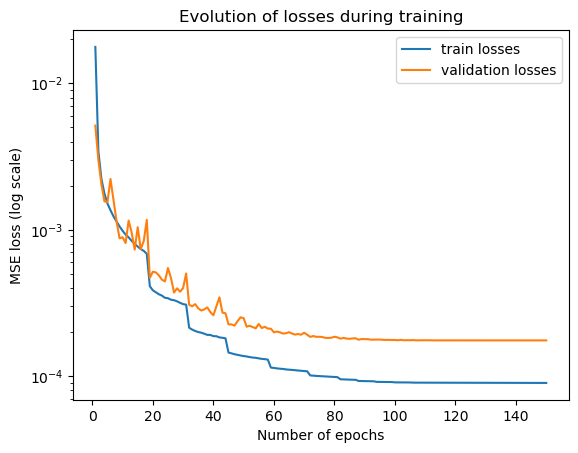

In [6]:
my_model = MapUpdateNetwork_7()
model, train_losses, validation_losses = load_my_model(
    'model/iFmodel7_C4_2to50que_150epochs_2560kaugtraindata_batchsize256_minlr8.pth', my_model, plot=True)

## C) Load the map

In [7]:
def fill_nans_with_mean(map_emg):
    """
    Remplace toutes les valeurs NaN dans l'array par la moyenne des valeurs voisines valides.
    
    Args:
        map_emg (np.ndarray): Array 2D contenant des valeurs et éventuellement des NaN.
    
    Returns:
        np.ndarray: Array où les NaN ont été remplacés par la moyenne de leurs voisins valides.
    """
    # Obtenir les dimensions de la carte
    rows, cols = map_emg.shape
    
    # Copier l'array pour éviter de modifier l'original
    filled_map = map_emg.copy()
    
    # Parcourir toutes les positions de l'array
    for x in range(rows):
        for y in range(cols):
            if np.isnan(filled_map[x, y]):  # Vérifier si la cellule est NaN
                # Collecter les valeurs voisines
                neighbors = []
                for i in [-1, 0, 1]:
                    for j in [-1, 0, 1]:
                        # S'assurer que les indices sont valides (dans les limites de l'array)
                        if 0 <= x + i < rows and 0 <= y + j < cols and not (i == 0 and j == 0):
                            neighbor_value = filled_map[x + i, y + j]
                            if not np.isnan(neighbor_value):
                                neighbors.append(neighbor_value)
                
                # Si des voisins valides existent, calculer la moyenne et remplacer le NaN
                if neighbors:
                    filled_map[x, y] = np.mean(neighbors)
    
    return filled_map

In [8]:
def map_plot(my_map, title: str = 'map', figsize=(6, 6)):
    """
    Plots a 2D map with color scale and values displayed at each cell.

    This function visualizes a 2D matrix (`my_map`) using a color map, with the values of the 
    matrix displayed at each corresponding location. The color range is automatically scaled 
    to the minimum and maximum values of the matrix, and a color bar is included to indicate 
    the value scale. The function allows customization of the plot title.

    Args:
        my_map (numpy.ndarray): A 2D numpy array to be plotted.
        title (str, optional): The title of the plot. Default is 'map'.

    Returns:
        None: The function displays the plot but does not return anything.
    
    Example:
        map_plot(np.array([[1, 2], [3, 4]]), 'Sample Map')
    """
    # Set up the figure with a fixed size
    plt.figure(figsize=figsize)
    
    # Display the map using a color map and scale it according to the minimum and maximum values
    plt.imshow(my_map, cmap='coolwarm', vmin=np.nanmin(my_map), vmax=np.nanmax(my_map))
    
    # Add a color bar to indicate the value scale
    plt.colorbar(label="values")
    
    # Set the title of the plot
    plt.title(title)

    # Loop over each cell of the matrix to display the value in the center of the cell
    for i in range(my_map.shape[0]):
        for j in range(my_map.shape[1]):
            plt.text(j, i, f"{my_map[i, j]:.3g}", ha='center', va='center', color="white", fontsize=8)

    # Show the plot
    plt.show()

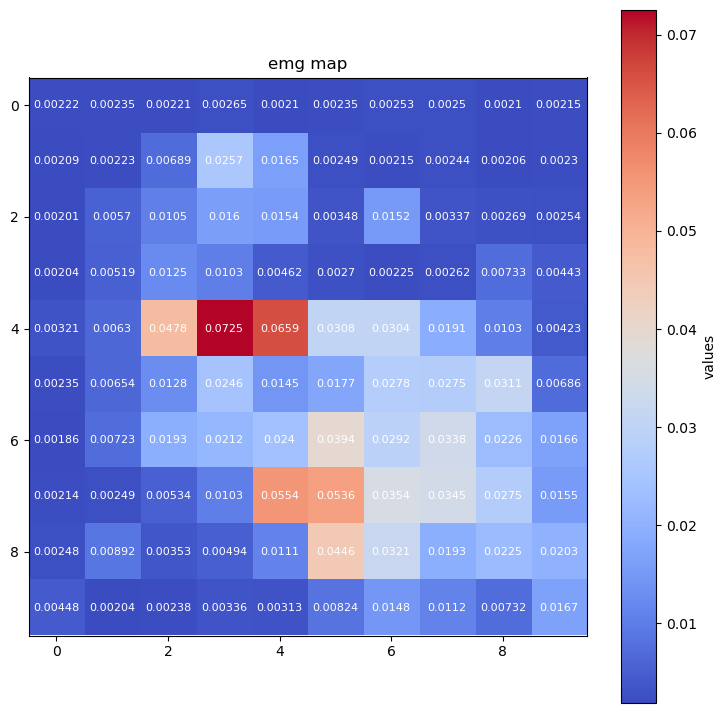

In [9]:
# Load dataset and extract relevant data 
ds = DataSet('../data/', 'nhp', 'Cebus1_M1_190221.mat', 'ceb1')  # Initialize the dataset with the path, animal type, file, and dataset name
ds.load_matlab_data()  # Load the data from the specified MATLAB file

emg = 1

# Extract relevant variables from the dataset
ch2xy = ds.set['ch2xy']  # Channel to (x, y) position mapping
sorted_respMean = ds.set['sorted_respMean']  # Sorted response means
output = sorted_respMean[:, emg]  # Select the 5th column of the sorted response means, i.e. the responses of the 5th emg 

# Initialize an empty map for EMG values, with shape based on the maximum x and y positions
map_emg = np.full((np.max(ch2xy[:, 0]), np.max(ch2xy[:, 1])), np.nan)

# Loop over each channel and assign its response mean value to the corresponding position in the EMG map
for i in range(ch2xy.shape[0]):
    # Convert the (x, y) position to zero-based indices and set the EMG value at that position
    map_emg[int(ch2xy[i, 0] - 1), int(ch2xy[i, 1] - 1)] = output[i]

if np.isnan(map_emg).any():
    map_emg = fill_nans_with_mean(map_emg)

# Plot the generated EMG map using the previously defined map_plot function
map_plot(map_emg, 'emg map', figsize=(9,9))

In [10]:
map = torch.tensor(map_emg, dtype=torch.float64)

## D) Sequence of queries

In [11]:
sequence = torch.randint(0, 10, (200, 2))
print(sequence[:10])

tensor([[0, 4],
        [8, 6],
        [5, 6],
        [0, 5],
        [3, 2],
        [4, 5],
        [8, 3],
        [2, 7],
        [1, 1],
        [2, 9]])


## E) utilities 

In [8]:
# Définir 10 points uniformément espacés entre 0 et 1
grid_1d = torch.linspace(0, 1, 10)

# Créer la grille 2D en combinant les coordonnées
x, y = torch.meshgrid(grid_1d, grid_1d, indexing='ij')

# Empiler les coordonnées sous forme de liste de points (100,2)
grid = torch.stack([x.flatten(), y.flatten()], dim=1)

print(grid.shape)  # Vérification de la taille (100,2)
print(grid[:5])   # Affichage des 10 premiers points

torch.Size([100, 2])
tensor([[0.0000, 0.0000],
        [0.0000, 0.1111],
        [0.0000, 0.2222],
        [0.0000, 0.3333],
        [0.0000, 0.4444]])


In [6]:
def create_space_test(shape):
    coords = [torch.linspace(0, 1, dim) for dim in shape]
    grid = torch.stack(torch.meshgrid(*coords, indexing='ij'), dim=-1)
    return grid.reshape(-1, len(shape))

a=create_space_test((10,10))

In [13]:
maps_elem_mean = torch.full((len(grid),1 , 1, 10, 10), np.nan)
maps_elem_std = torch.full((len(grid),1 , 1, 10, 10), np.nan)


for i in range(len(grid)):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    elem_gp = GPytorchFixed(
                    train_x=grid[i:i+1], train_y=torch.tensor([1.]), 
                    likelihood=likelihood, kernel_type='Matern52', noise=0.05, 
                    outputscale=1, lengthscale=[0.3, 0.3])
    elem_gp.double()
    elem_mean, elem_std = elem_gp.predict(grid)
    for j in range(len(grid)):
        maps_elem_mean[i, 0, 0, int(grid[j,0]*9 + 0.01), int(grid[j,1]*9 + 0.01)] = elem_mean[j].detach().item()
        maps_elem_std[i, 0, 0, int(grid[j,0]*9 + 0.01), int(grid[j,1]*9 + 0.01)] = elem_std[j].detach().item()

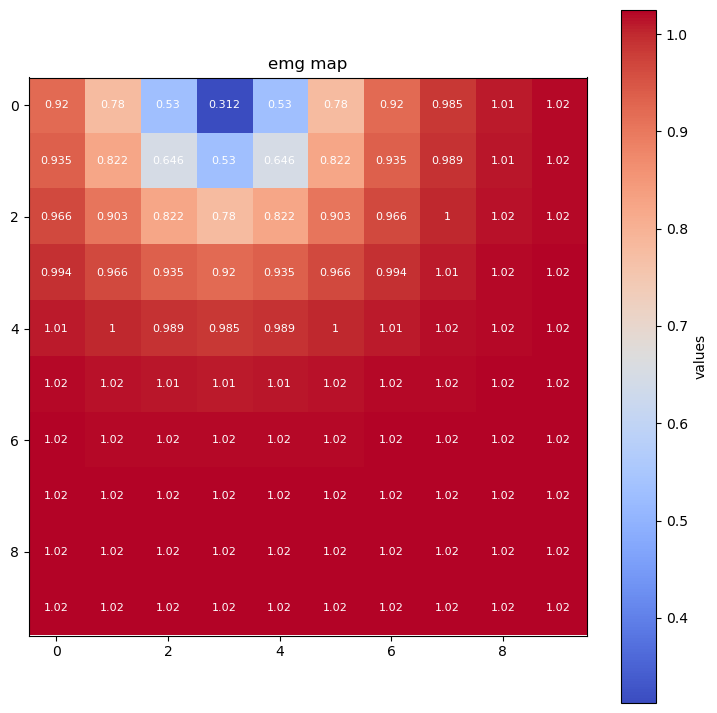

In [14]:
map_plot(maps_elem_std[3,0,0], 'emg map', figsize=(9,9))

In [18]:
k, l = int(grid[5,0]*9 + 0.01), int(grid[5,1]*9 + 0.01)
print(k,l)

0 5


## F) Simulate online GP using the NN model

In [15]:
input = torch.cat((maps_elem_mean[43], maps_elem_std[43], maps_elem_std[77], maps_elem_mean[77]), dim=1)
output = model(*torch.split(input, 1, dim=1))
print(output.shape)

torch.Size([1, 2, 10, 10])


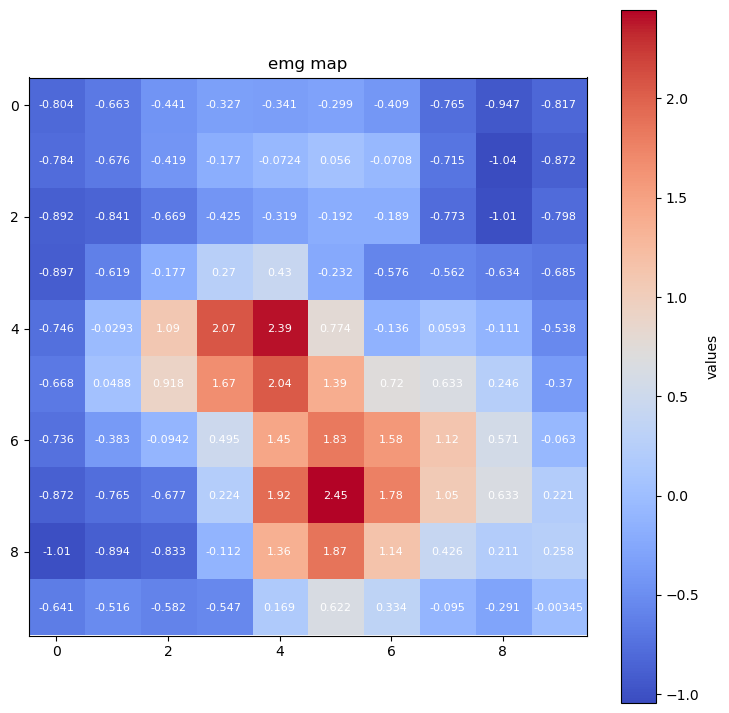

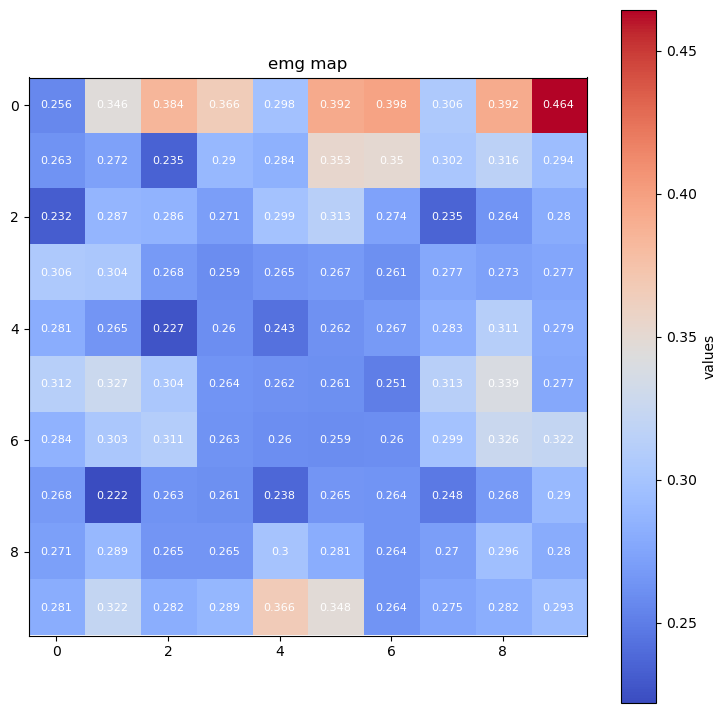

In [37]:
map_plot(output[0,0].detach().numpy(), 'emg map', figsize=(9,9))
map_plot(output[0,1].detach().numpy(), 'emg map', figsize=(9,9))

In [17]:
position = sequence[0]
print(position)
print(grid[10*position[0]+position[1]])


tensor([0, 4])
tensor([0.0000, 0.4444])


In [18]:
nb_queries = 100

mean_pred_list = []
std_pred_list = []

mean = 0
var = 0

for it in range (nb_queries):

    position = sequence[it]
    id_position = 10*position[0]+position[1]
    value = map[*position]

    if it == 0:
        new_mean = value
        new_var = 0
        mean_pred = maps_elem_mean[id_position]
        std_pred = maps_elem_std[id_position]
    else:
        new_mean = ((it*mean + value)/(it+1))
        new_var = (it * (var + (new_mean-mean)**2) + (value-new_mean)**2) / (it+1)
        modified_value = (value - new_mean) / math.sqrt(new_var)
        input = torch.cat((mean_pred, std_pred, maps_elem_std[id_position], maps_elem_mean[id_position]*modified_value), dim=1)
        output = model(*torch.split(input, 1, dim=1))
        mean_pred = output[:,0:1]
        std_pred = output[:,1:2]

    mean = new_mean
    var = new_var

    mean_pred_list.append(mean_pred)
    std_pred_list.append(std_pred)


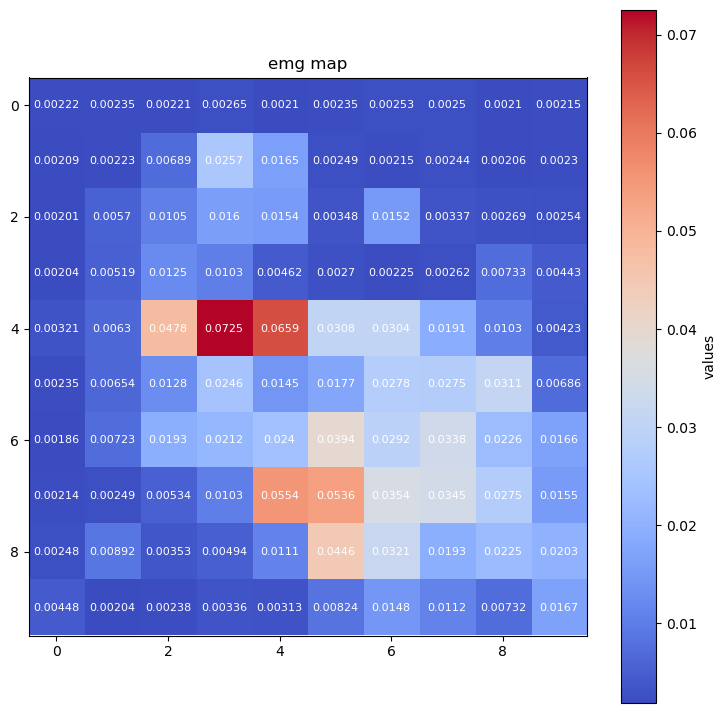

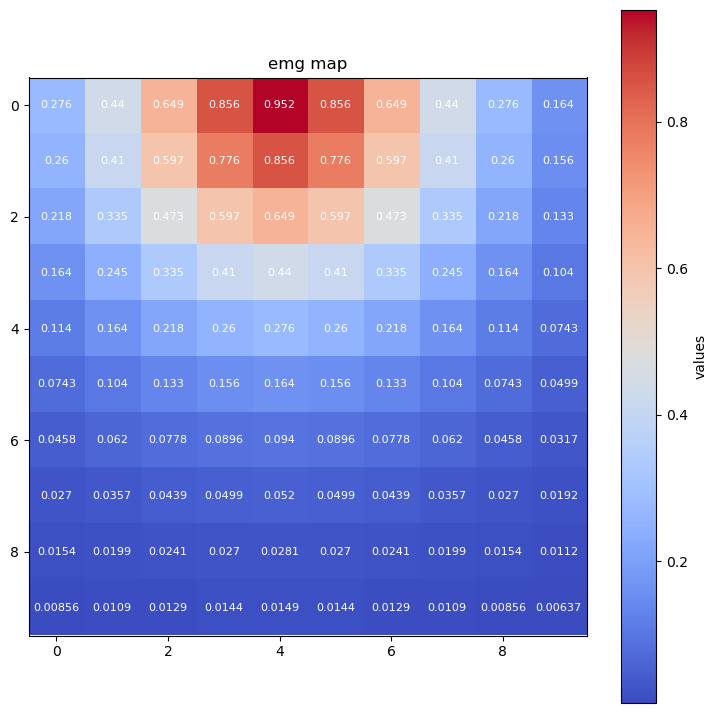

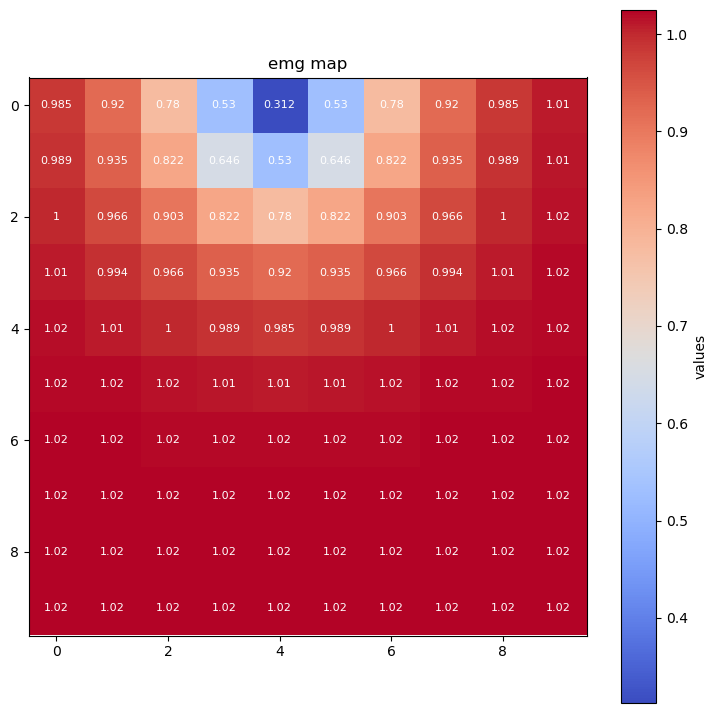

In [19]:
it = 0
map_plot(map, 'emg map', figsize=(9,9))
map_plot(mean_pred_list[it][0,0].detach().numpy(), 'emg map', figsize=(9,9))
map_plot(std_pred_list[it][0,0].detach().numpy(), 'emg map', figsize=(9,9))

## G) Simulate with GP

In [20]:
nb_queries = 100

GPmean_pred_list = []
GPstd_pred_list = []

mean = 0
var = 0

train_x = []
train_y = []

for it in range (nb_queries):

    position = sequence[it]
    id_position = 10*position[0]+position[1]
    value = map[*position]

    train_x.append(grid[id_position].tolist())
    train_y.append(value)
    tX = torch.tensor(train_x, dtype=torch.float64)
    tY = torch.tensor(train_y, dtype=torch.float64)

    if it==0:
        tY = torch.tensor([1.], dtype=torch.float64)
    else:
        tY = (tY-tY.mean())/tY.std(correction=0)

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    gp = GPytorchFixed(
            train_x=tX, 
            train_y=tY, 
            likelihood=likelihood, 
            kernel_type='Matern52',
            lengthscale=[0.3,0.3],
            outputscale=1.,
            noise=0.05
        )

    gp.double()
    mean_pred, std_pred = gp.predict(grid)
    maps_mean = torch.full((10, 10), np.nan)
    maps_std = torch.full((10, 10), np.nan)
    for j in range(len(grid)):
        maps_mean[int(grid[j,0]*9 + 0.01), int(grid[j,1]*9 + 0.01)] = mean_pred[j].detach().item()
        maps_std[int(grid[j,0]*9 + 0.01), int(grid[j,1]*9 + 0.01)] = std_pred[j].detach().item()

    GPmean_pred_list.append(maps_mean)
    GPstd_pred_list.append(maps_std)

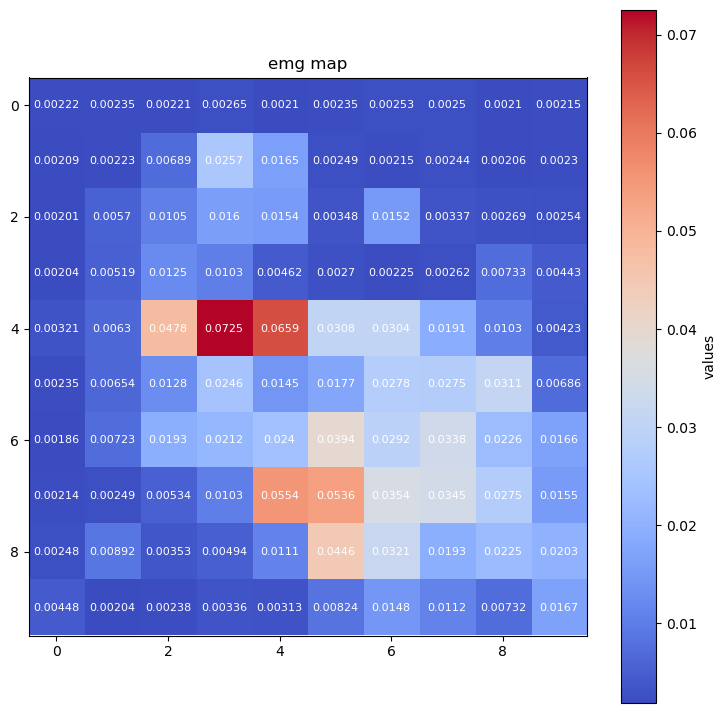

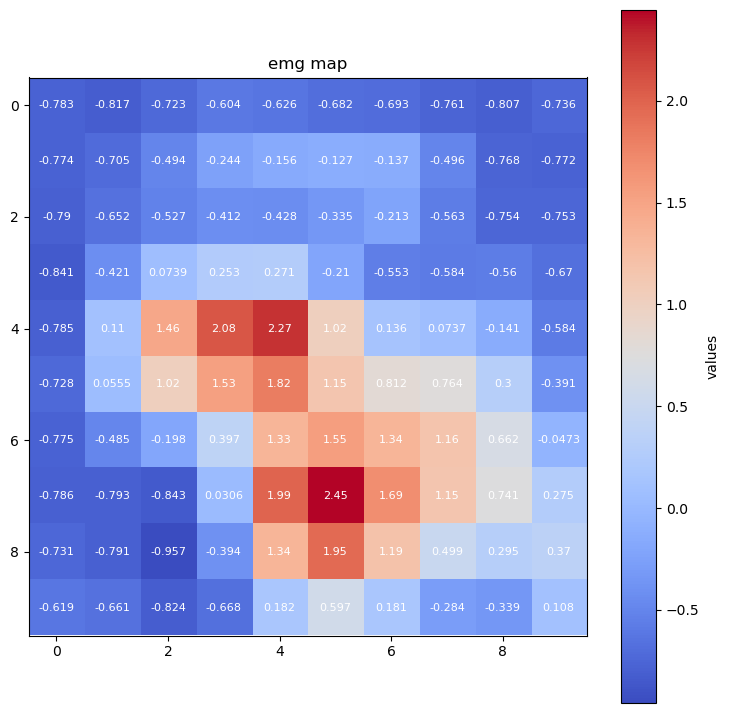

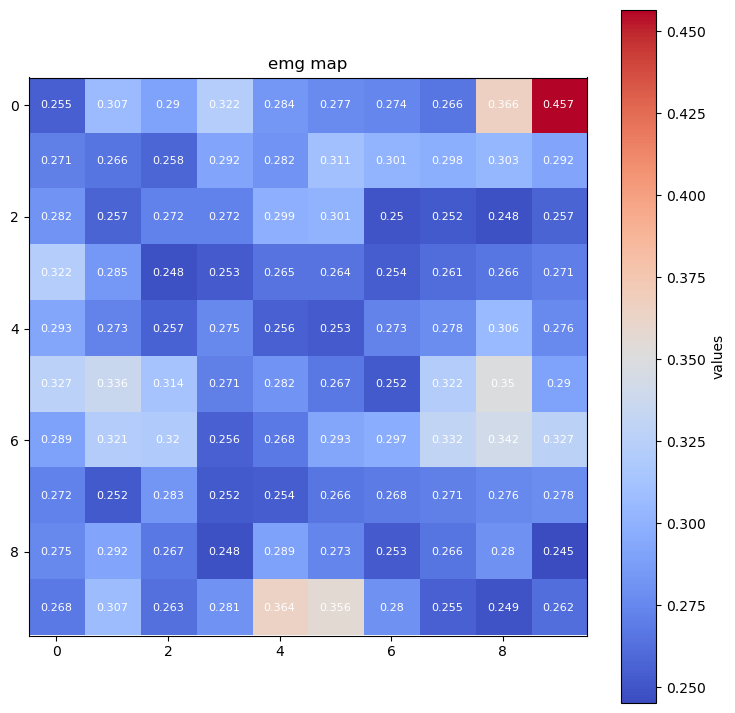

In [21]:
it = 99
map_plot(map, 'emg map', figsize=(9,9))
map_plot(GPmean_pred_list[it].detach().numpy(), 'emg map', figsize=(9,9))
map_plot(GPstd_pred_list[it].detach().numpy(), 'emg map', figsize=(9,9))

In [23]:
np.std(a.numpy(),ddof=0)

1.0

In [24]:
tY = torch.tensor([1,2,3], dtype=torch.float64)
tY = (tY-tY.mean())/tY.std(correction=0)
print(tY)

tensor([-1.2247,  0.0000,  1.2247], dtype=torch.float64)


In [25]:
def compare_GP_NN(mean_GP, std_GP, mean_NN, std_NN, it, values: bool = False, figsize=(10, 8)):
    """

    """
    
    # Define the figure and axes for the subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize) 
    
    # Define the maps for the plots
    maps = [mean_GP[it].detach(), mean_NN[it][0,0].detach(), 
            std_GP[it].detach(), std_NN[it][0,0].detach()]
    
    # Titles for the plots
    titles = ["mean map GP", "mean map NN",
              "std map GP", "std map NN"]
    
    # Normalize the color scale for the std maps and other maps
    std_maps = [std_GP[it].detach(), std_NN[it][0,0].detach()]
    other_maps = [mean_GP[it].detach(), mean_NN[it][0,0].detach()]
    
    std_min = torch.min(torch.stack(std_maps))
    std_max = torch.max(torch.stack(std_maps))
    other_min = torch.min(torch.stack(other_maps))
    other_max = torch.max(torch.stack(other_maps))
    
    # Plot the maps
    for idx, ax in enumerate(axes.flat):
        # Select colormap and normalization based on the type of map
        if idx in [2, 3]:  # std maps
            cax = ax.imshow(maps[idx], cmap='cividis', vmin=0, vmax=std_max)
        else:  # other maps
            cax = ax.imshow(maps[idx], cmap='coolwarm', vmin=other_min, vmax=other_max)
        
        ax.set_title(titles[idx])
        plt.colorbar(cax, ax=ax)
        
        # Add cell values as text if values=True
        if values:
            data = maps[idx].cpu().numpy()  # Convert tensor to numpy array
            for i in range(data.shape[0]):
                for j in range(data.shape[1]):
                    ax.text(j, i, f"{data[i, j]:.3g}", ha='center', va='center', 
                            color="white", fontsize=6)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

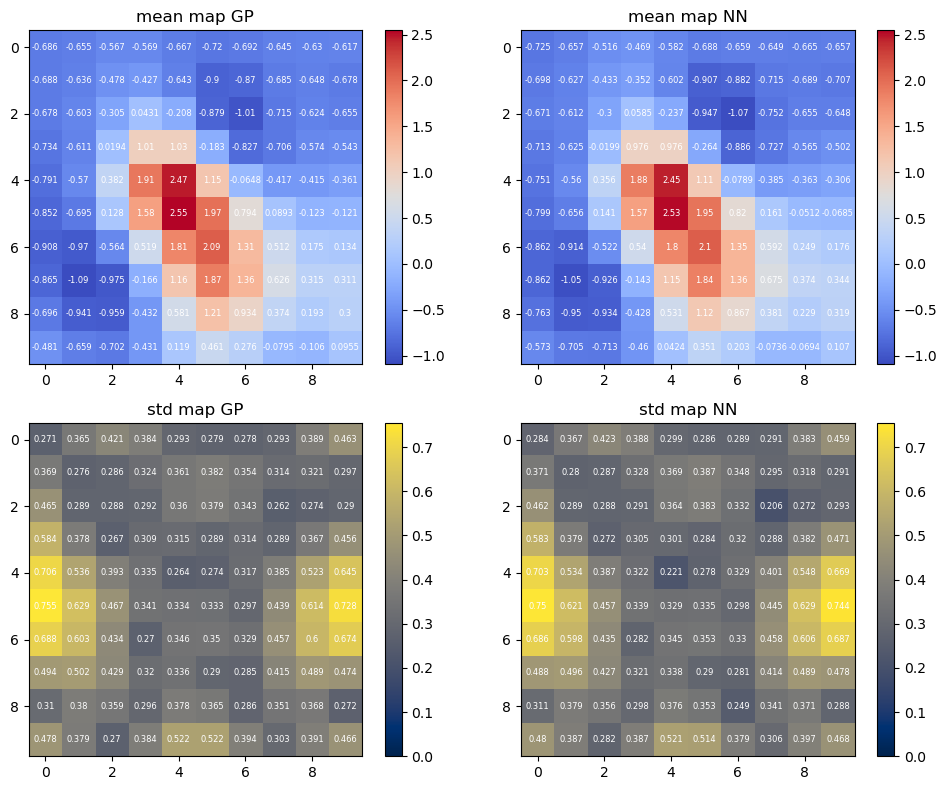

In [36]:
compare_GP_NN(GPmean_pred_list, 
              GPstd_pred_list, 
              mean_pred_list, 
              std_pred_list, 
              it = 34, 
              values=True)

In [33]:
import imageio

def create_GP_NN_gif(mean_GP, std_GP, mean_NN, std_NN, values: bool = False, figsize=(10, 8), fps=5, filename="GP_NN_animation.gif"):
    """
    Génère un GIF en faisant varier l'itération 'it' de 0 à len(mean_GP).
    """
    frames = []
    num_frames = len(mean_GP)  # Nombre d'itérations

    for it in range(num_frames):
        # Créer la figure
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Définir les maps pour les plots
        maps = [mean_GP[it].detach(), mean_NN[it][0,0].detach(), 
                std_GP[it].detach(), std_NN[it][0,0].detach()]

        # Titres des subplots
        titles = ["mean map GP", "mean map NN",
                  "std map GP", "std map NN"]

        # Normalisation des couleurs
        std_maps = [std_GP[it].detach(), std_NN[it][0,0].detach()]
        other_maps = [mean_GP[it].detach(), mean_NN[it][0,0].detach()]
        
        std_max = torch.max(torch.stack(std_maps))
        other_min = torch.min(torch.stack(other_maps))
        other_max = torch.max(torch.stack(other_maps))

        # Tracé des subplots
        for idx, ax in enumerate(axes.flat):
            if idx in [2, 3]:  # std maps
                cax = ax.imshow(maps[idx], cmap='cividis', vmin=0, vmax=std_max)
            else:  # other maps
                cax = ax.imshow(maps[idx], cmap='coolwarm', vmin=other_min, vmax=other_max)

            ax.set_title(titles[idx])
            plt.colorbar(cax, ax=ax)

            # Ajouter les valeurs si values=True
            if values:
                data = maps[idx].cpu().numpy()  # Convertir en numpy array
                for i in range(data.shape[0]):
                    for j in range(data.shape[1]):
                        ax.text(j, i, f"{data[i, j]:.3g}", ha='center', va='center', 
                                color="white", fontsize=6)
            
        # Ajouter un compteur d'itérations en dehors des subplots (dans le titre de la figure)
        fig.suptitle(f"Iteration {it+1}/{num_frames}", fontsize=16, fontweight="bold", color="red")

        # Sauvegarde de la frame en image temporaire
        temp_filename = f"gif/image/frame_{it}.png"
        plt.tight_layout()
        plt.savefig(temp_filename)
        plt.close(fig)

        frames.append(imageio.imread(temp_filename))

    # Création du GIF
    imageio.mimsave(f"gif/{filename}", frames, fps=fps)
    print(f"GIF sauvegardé sous {filename}")



In [34]:
create_GP_NN_gif(GPmean_pred_list[:50], 
              GPstd_pred_list[:50], 
              mean_pred_list[:50], 
              std_pred_list[:50])

GIF sauvegardé sous GP_NN_animation.gif


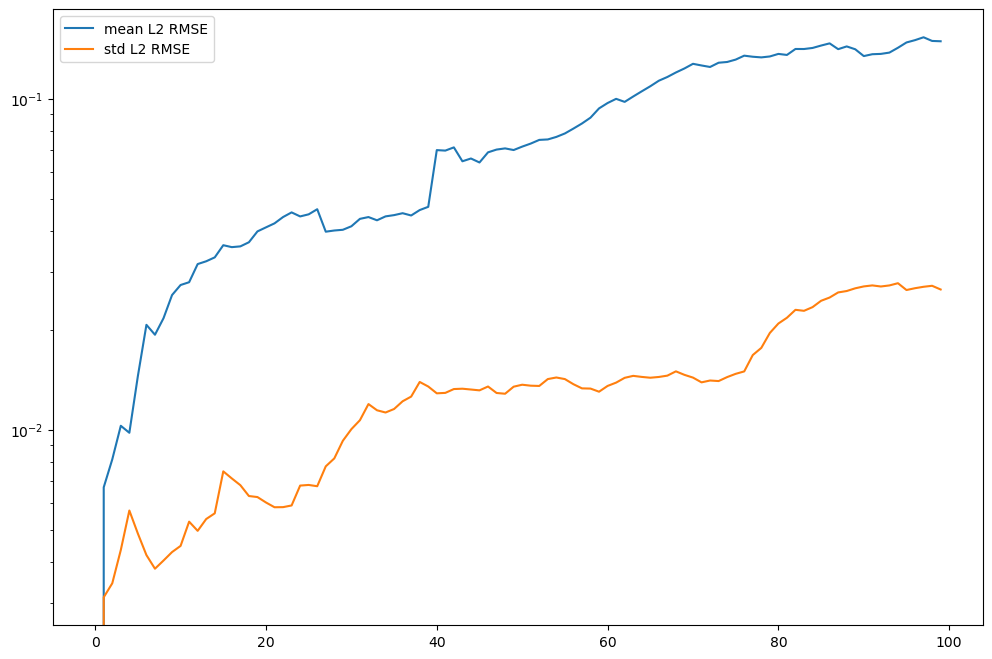

In [53]:
mean_list_L2_error = []
std_list_L2_error = []

for it in range(len(mean_pred_list)):
    L2error_mean = torch.sqrt(0.01 * torch.sum((GPmean_pred_list[it].detach() - mean_pred_list[it][0,0].detach())**2))
    L2error_std = torch.sqrt(0.01 * torch.sum((GPstd_pred_list[it].detach() - std_pred_list[it][0,0].detach())**2))
    mean_list_L2_error.append(L2error_mean)
    std_list_L2_error.append(L2error_std)

plt.figure(figsize=(12,8))
plt.plot(mean_list_L2_error, label='mean L2 RMSE')
plt.plot(std_list_L2_error, label='std L2 RMSE')
plt.legend()
plt.yscale('log')
plt.show()

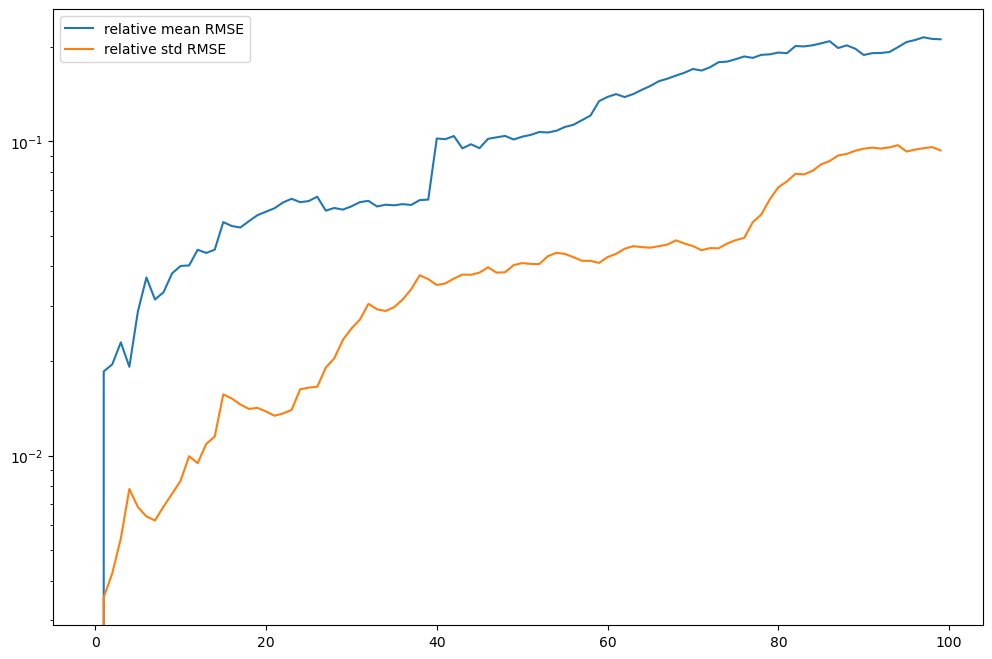

In [54]:
mean_list_L2_error = []
std_list_L2_error = []

for it in range(len(mean_pred_list)):
    L2error_mean = torch.sqrt(0.01 * torch.sum((GPmean_pred_list[it].detach() - mean_pred_list[it][0,0].detach())**2)) / torch.mean(torch.abs(GPmean_pred_list[it].detach()))
    L2error_std = torch.sqrt(0.01 * torch.sum((GPstd_pred_list[it].detach() - std_pred_list[it][0,0].detach())**2)) / torch.mean(GPstd_pred_list[it].detach())
    mean_list_L2_error.append(L2error_mean)
    std_list_L2_error.append(L2error_std)

plt.figure(figsize=(12,8))
plt.plot(mean_list_L2_error, label='relative mean RMSE')
plt.plot(std_list_L2_error, label='relative std RMSE')
plt.legend()
plt.yscale('log')
plt.show()

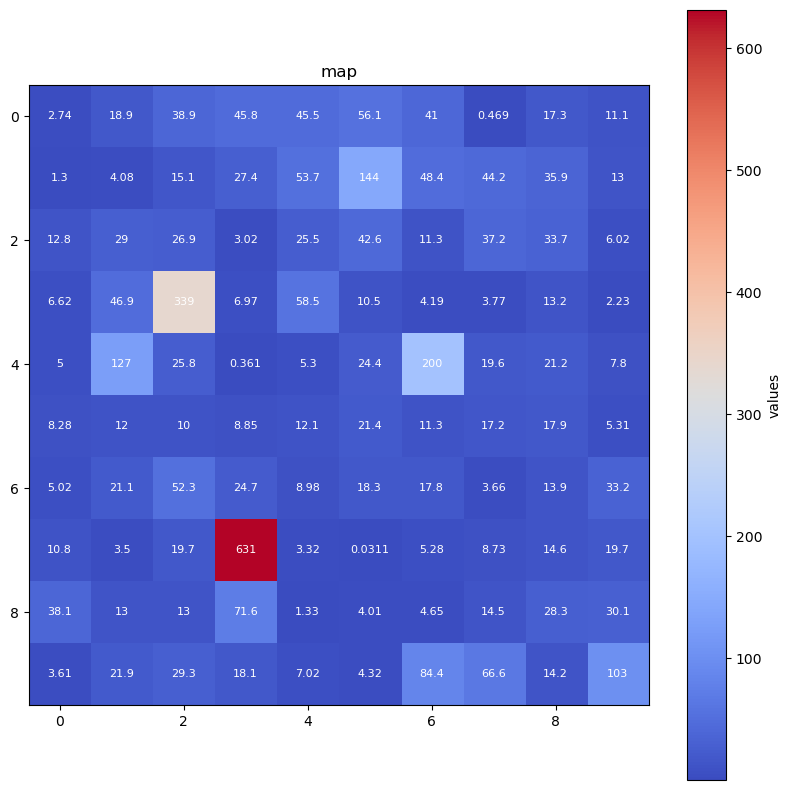

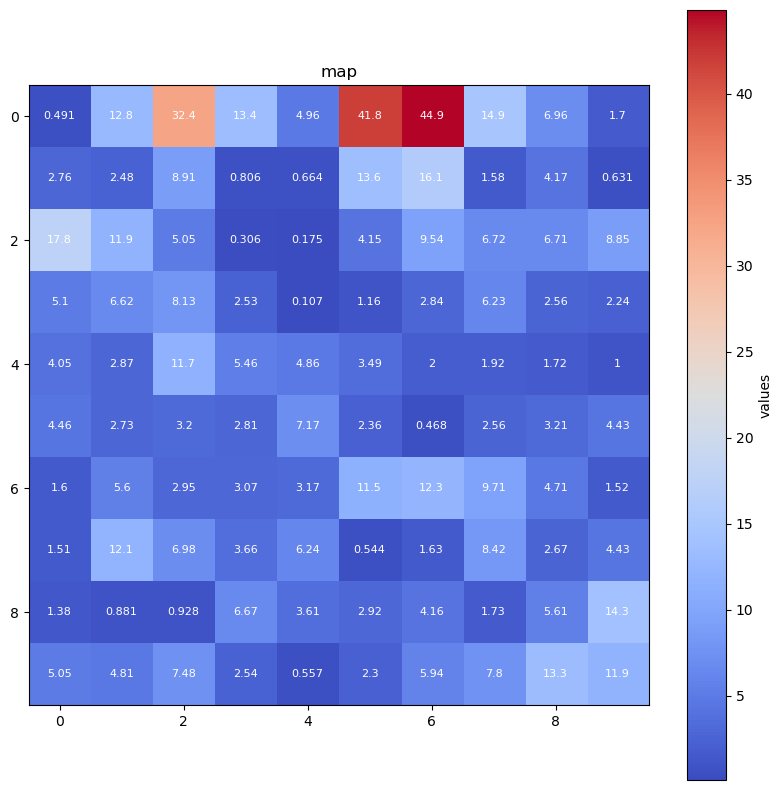

In [57]:
Rel_error_mean = torch.abs(GPmean_pred_list[it].detach() - mean_pred_list[it][0,0].detach())/torch.abs(GPmean_pred_list[it].detach())*100
Rel_error_std = torch.abs(GPstd_pred_list[it].detach() - std_pred_list[it][0,0].detach())/torch.abs(GPstd_pred_list[it].detach())*100

map_plot(Rel_error_mean, figsize=(10,10))
map_plot(Rel_error_std, figsize=(10,10))

In [58]:
print(it)

99


In [68]:
sequence[49]

tensor([5, 6])

In [66]:
GPmean_pred_list[49][2,7]

tensor(-0.7396)

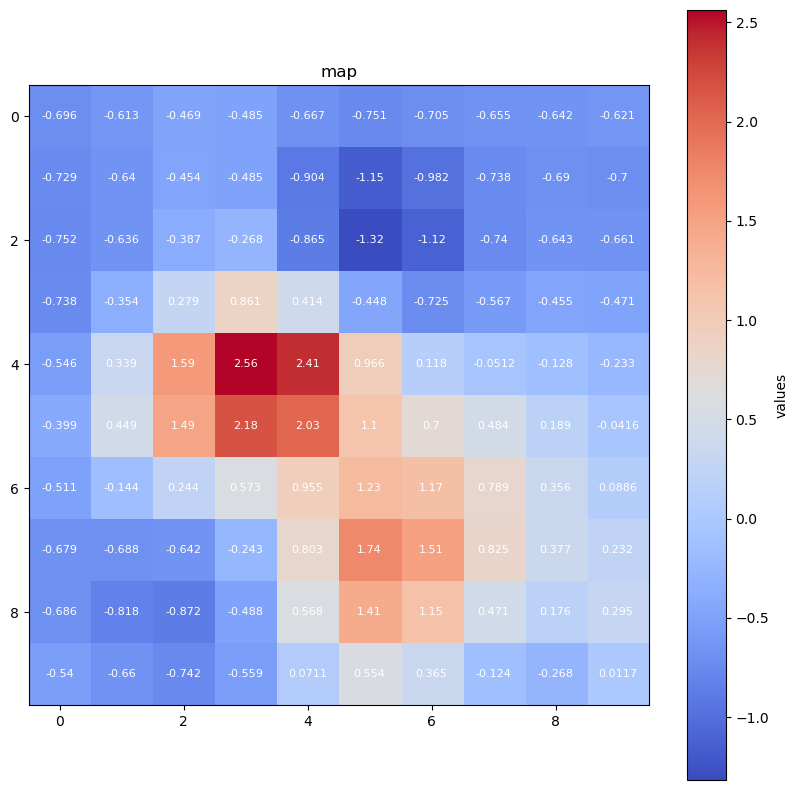

In [67]:
map_plot(GPmean_pred_list[49], figsize=(10,10))